# Trigger failures

**Goal:** Let's take a second to look at what kind of events are *failing* the trigger, and what we can learn from this!

**Reminder:** In the first two steps of the cutflow, we only keep 2% of our signal... I want to focus on the events that we're losing between XhhCommon and the 2015 triggers.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import glob
import uproot

from scipy.stats import pearsonr

import os
import sys
sys.path.append("../code")
from preprocess import read_tsv, fileDir
from plotting import varEvolution, massPlane, normHist2d
from eventDisplays import truthInfo

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
physicsSample = 'SMNR'
nFiles = 5 # If we want to run over MORE THAN ONE file, but a subset of the ttl # of events 

trigger = '2016_triggers'

In [4]:
fDir = "../data/{}_PFlow/".format(physicsSample)

if physicsSample == 'SMNR':
    
    fName = "files/df_f_0.22_00*.h5"

In [5]:
myFiles = fDir + fName
dfs = []

for i, myFile in enumerate(glob.glob(myFiles)[:nFiles]):

    print('{}. {}'.format(i+1,myFile))
    
    df = pd.read_hdf(myFile,key='df')
    dfs.append(df)

miniNtuple = pd.concat(dfs)

1. ../data/SMNR_PFlow/files/df_f_0.22_000009.h5
2. ../data/SMNR_PFlow/files/df_f_0.22_000018.h5
3. ../data/SMNR_PFlow/files/df_f_0.22_000010.h5
4. ../data/SMNR_PFlow/files/df_f_0.22_000005.h5
5. ../data/SMNR_PFlow/files/df_f_0.22_000002.h5


### 2015 Triggers

The last iteration used a combination of three triggers for each year


**2015**
1. `HLT_2j35_btight_2j35_L14J15.0ETA25`
2. `HLT_j100_2j55_bmedium`
3. `HLT_j225_bloose`


**2016**
1. `HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25`
2. `HLT_j100_2j55_bmv2c2060_split`
3. `HLT_j225_bmv2c2060_split`


Since I want to look at events that didn't pass the trigger, a lot of the extra variables that I create in `preprocess.py` won't be made, so I think I'll have to do a lot of the preprocessing on my own!

**Some basic plots**
- number of jets
- number of b-jets
- $p_T$s of the jets
- $\eta$s of the jets

Since these are the types of things that we're cutting on in these triggers, although on physics objects with larger errors.

In [6]:
minPts = [min(pts) for pts in miniNtuple.resolvedJets_pt]
plt.hist(minPts,100,(0,100))
plt.title('SM NR: FEB 2019 miniNtuple Production')
plt.ylabel('Entries',fontsize=12)
plt.xlabel('min resolvedJets_pt [GeV]',fontsize=12)

ylim = plt.ylim()
plt.plot([25]*2,ylim,'k--')
plt.ylim(ylim)

plt.savefig("../figures/SMNR_16/min_resolvedJets_pt.pdf")

plt.show()

In [7]:
mask = ( ~miniNtuple[trigger] )

In [8]:
figDir = "../figures/SMNR_{}/failed_{}_triggers/".format(trigger[2:4],trigger[:4])
my_title = '{}: Failed {} triggers'.format(physicsSample,trigger[:4])

In [9]:
figDir

'../figures/SMNR_16/failed_2016_triggers/'

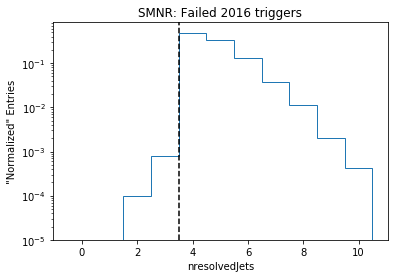

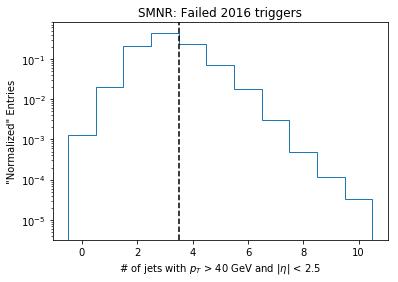

In [10]:
for log, logTag in zip([False,True],['','_log']):
    
    for v,xlabel in zip(['nresolvedJets','njets'],['nresolvedJets','# of jets with $p_T$ > 40 GeV and $|\eta|$ < 2.5']):
        
        plt.figure()
        plt.hist(miniNtuple.loc[mask,v],11,(-0.5,10.5),
                 weights=miniNtuple.loc[mask,'mc_sf'],
                 histtype='step',density=True,log=log)
        plt.xlabel(xlabel)

        plt.title(my_title)
        ylim = plt.ylim()
        plt.plot([3.5]*2,ylim,'k--')
        plt.ylim(ylim)
        plt.ylabel('"Normalized" Entries')

        plt.savefig("{}/{}.pdf".format(figDir,v),bbox_inches='tight')
    
plt.show()

In [11]:
np.sum(miniNtuple.loc[mask & (miniNtuple.njets < 4),'mc_sf']) / np.sum(miniNtuple.loc[mask,'mc_sf'])

0.6748714456550154

So what the second plot is saying is that for the jets that *failed* the trigger, 70% of the time they wouldn't have passed our jet kinematics requirement anyways.

**Lessons:**
- So the plot of `nresolvedJets` demonstrates that with this signal, we *are* normally reconstructing at least 4 jets.
- However for the events failing the trigger, $\approx$ 40% of them would have failed the kinematic jet selection anyways.

## Truth information from the signal

I can also look at these events at truth level to see what types of topologies we're rejecting.

### $hh$ system

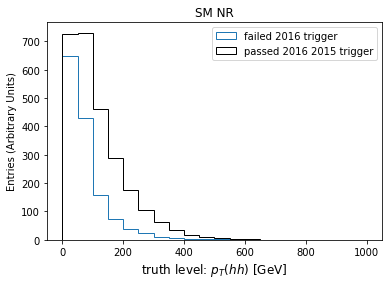

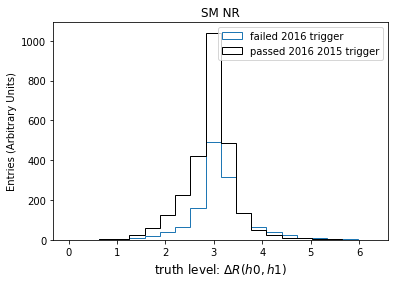

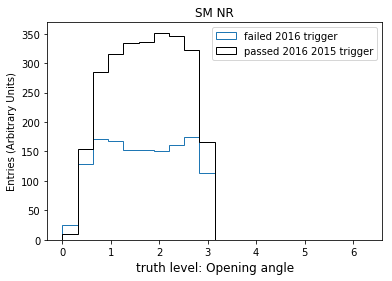

In [12]:
for var,xlabel,myRange in zip(['m','pt','dr','angle'],
                              ['$m_{hh}$ [GeV]','$p_T(hh)$ [GeV]','$\Delta R(h0,h1)$','Opening angle'],
                              [(0,1250),(0,1000),(0,2*np.pi),(0,2*np.pi)]):
    
    plt.hist(miniNtuple.loc[mask,'hh_'+var],
             bins=20, range=myRange, label='failed {} trigger'.format(trigger[:4]),
             histtype='step', color='C0', #density=True, 
             weights=miniNtuple.loc[mask,'mc_sf'])

    plt.hist(miniNtuple.loc[~mask,'hh_'+var],
             bins=20, range=myRange, label='passed {} 2015 trigger'.format(trigger[:4]),
             histtype='step', color='k', #density=True, 
             weights=miniNtuple.loc[~mask,'mc_sf'])
    
    plt.xlabel('truth level: '+xlabel,fontsize=12)
    plt.ylabel("Entries (Arbitrary Units)")
    plt.title('SM NR')
    plt.legend()
    plt.savefig('{}/hh_{}.pdf'.format(figDir,var))
    plt.show()

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


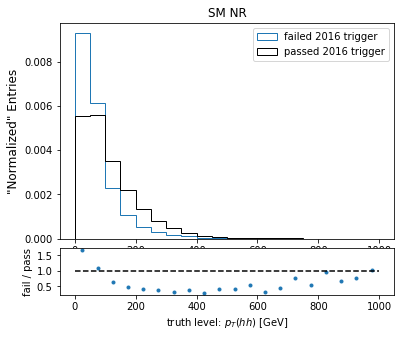

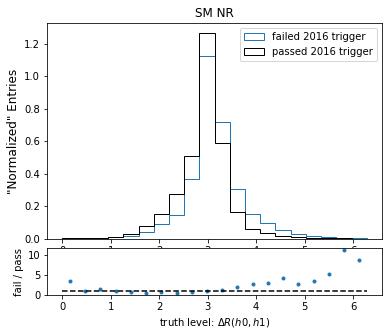

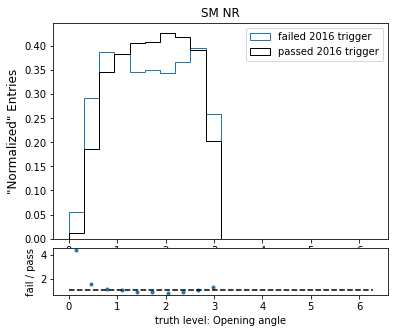

In [16]:
for var,xlabel,myRange in zip(['m','pt','dr','angle'],
                              ['$m_{hh}$ [GeV]','$p_T(hh)$ [GeV]','$\Delta R(h0,h1)$','Opening angle'],
                              [(0,1250),(0,1000),(0,2*np.pi),(0,2*np.pi)]):
    
    fig = plt.figure(figsize=(6,5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4:,0])

    n_fail,edg,_ = ax1.hist(miniNtuple.loc[mask,'hh_'+var], bins=20, range=myRange, 
                            label='failed {} trigger'.format(trigger[:4]),
                            histtype='step', color='C0', density=True, 
                            weights=miniNtuple.loc[mask,'mc_sf'])

    n_pass,edg,_ = ax1.hist(miniNtuple.loc[~mask,'hh_'+var], bins=20, range=myRange, 
                            label='passed {} trigger'.format(trigger[:4]),
                            histtype='step', color='k', density=True, 
                            weights=miniNtuple.loc[~mask,'mc_sf'])

    ax2.plot(0.5 * (edg[:-1]+edg[1:]), n_fail / n_pass, 
             color='C0', marker='.', linewidth=0)


    ax1.set_ylabel("\"Normalized\" Entries",fontsize=12)
    ax1.set_title('SM NR')
    ax1.legend()

    ax2.set_xlabel('truth level: '+xlabel)
    ax2.set_ylabel('fail / pass')

    ax2.plot([edg[0],edg[-1]],[1]*2,'k--')

    plt.savefig('{}/hh_{}_ratio.pdf'.format(figDir,var))
    
plt.show()

Just looking at events that *failed* the trigger isn't that insightful, I think I'll need to overlay with the events that passed the trigger so that I have a comparison.

**Notes:**
- The events *failing* $m_{4j}$ have slightly lower $m_{hh}$ and less $p_T(hh)$
- I think this is an artifact of the jet turn-on curves
- The $\Delta R$ and opening angle plots were not particularly insightful to me.

### higgses

In [17]:
for c in df.columns:
    if 'h0' in c:
        print(c)

h0_pt
h0_eta
h0_phi
h0_E


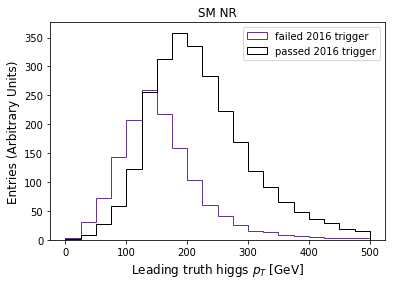

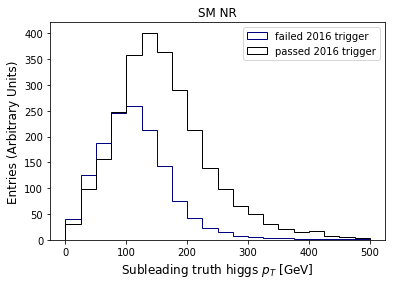

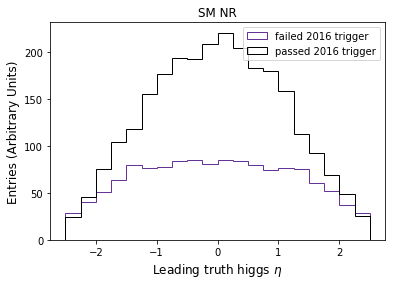

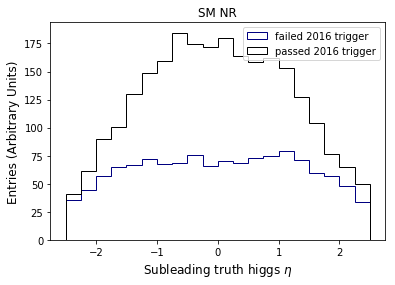

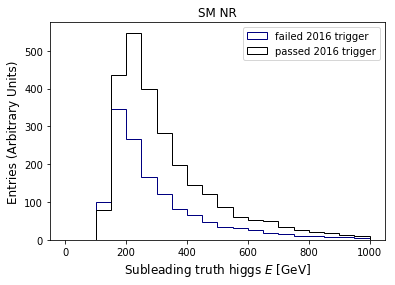

In [18]:
for var,xlabel,myRange in zip(['pt','eta','phi','E'],
                              ['$p_T$ [GeV]','$\eta$','$\phi$','$E$ [GeV]'],
                              [(0,500),(-2.5,2.5),(-np.pi,np.pi),(0,1000)]):
    
    for ih, htag, c in zip(range(2),['Leading','Subleading'],['rebeccapurple','navy']):
    
        key = 'h{}_{}'.format(ih,var)
    
        plt.hist(miniNtuple.loc[mask,key],
                 bins=20, range=myRange, label='failed {} trigger'.format(trigger[:4]),
                 histtype='step', color=c, #density=True, 
                 weights=miniNtuple.loc[mask,'mc_sf'])

        plt.hist(miniNtuple.loc[~mask,key],
                 bins=20, range=myRange, label='passed {} trigger'.format(trigger[:4]),
                 histtype='step', color='k', #density=True, 
                 weights=miniNtuple.loc[~mask,'mc_sf'])

        plt.xlabel(htag+' truth higgs '+xlabel,fontsize=12)
        plt.ylabel("Entries (Arbitrary Units)",fontsize=12)
        plt.title('SM NR')
        plt.legend()
        plt.savefig('{}/{}.pdf'.format(figDir,key))
        plt.show()

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


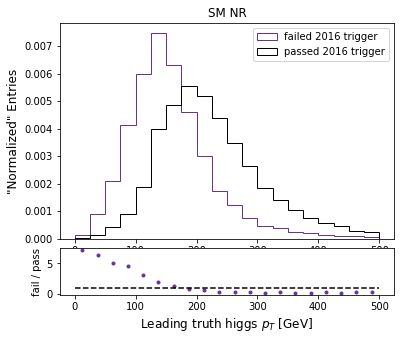

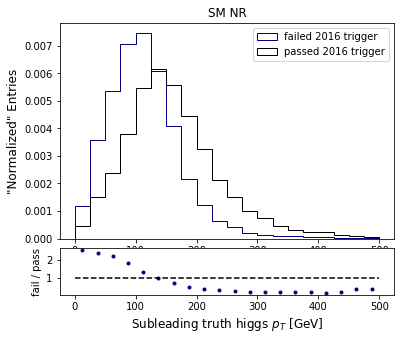

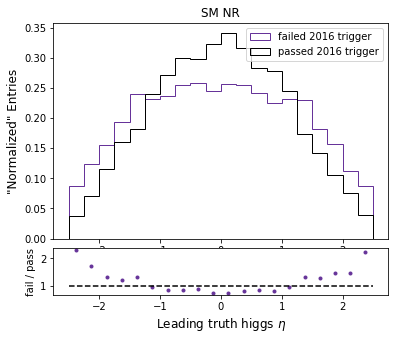

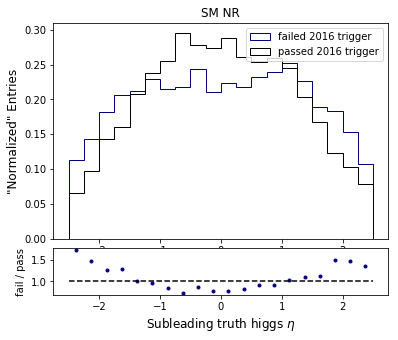

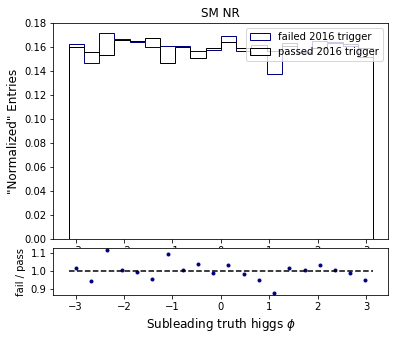

In [19]:
for var,xlabel,myRange in zip(['pt','eta','phi','E'],
                              ['$p_T$ [GeV]','$\eta$','$\phi$','$E$ [GeV]'],
                              [(0,500),(-2.5,2.5),(-np.pi,np.pi),(0,1000)]):
    
    for ih, htag, c in zip(range(2),['Leading','Subleading'],['rebeccapurple','navy']):
    
        key = 'h{}_{}'.format(ih,var)
    
    
        fig = plt.figure(figsize=(6,5))
        gs = gridspec.GridSpec(5,1)
        ax1 = fig.add_subplot(gs[:4,0])
        ax2 = fig.add_subplot(gs[4:,0])
    
        n_fail,edg,_ = ax1.hist(miniNtuple.loc[mask,key], bins=20, range=myRange, 
                                label='failed {} trigger'.format(trigger[:4]),
                                histtype='step', color=c, density=True, 
                                weights=miniNtuple.loc[mask,'mc_sf'])

        n_pass,edg,_ = ax1.hist(miniNtuple.loc[~mask,key], bins=20, range=myRange, 
                                label='passed {} trigger'.format(trigger[:4]),
                                histtype='step', color='k', density=True, 
                                weights=miniNtuple.loc[~mask,'mc_sf'])

        ax2.plot(0.5 * (edg[:-1]+edg[1:]), n_fail / n_pass, 
                 color=c, marker='.', linewidth=0)
        
        
        ax1.set_ylabel("\"Normalized\" Entries",fontsize=12)
        ax1.set_title('SM NR')
        ax1.legend()
        
        ax2.set_xlabel(htag+' truth higgs '+xlabel,fontsize=12)
        ax2.set_ylabel('fail / pass')
        
        ax2.plot([edg[0],edg[-1]],[1]*2,'k--')
        
        
        plt.savefig('{}/{}_ratio.pdf'.format(figDir,key))


Yep, these stories are consistent with the story that I was trying to tell about kinematic turn ons.

### $b$-quarks

In [20]:
jetVars = ['pt','eta','phi','E','drMatch'] 
nBinsAll = [[32,24,16,16]] + [[30]*4 for i in range(4)]
myRangesAll = [[(0,400),(0,300),(0,200),(0,200)],
               [(-3,3)]*4,[(-np.pi,np.pi)]*4,[(0,750)]*4,[(0,0.5)]*4]
xlabels = ['$p_T$ [GeV]','$\eta$','$\phi$','E [GeV]','$\Delta R$ to closest reco jet']

In [ ]:
len(nBinsAll)

5

In [ ]:
for myRanges in myRangesAll:
    
    print(myRanges)

[(0, 400), (0, 300), (0, 200), (0, 200)]
[(-3, 3), (-3, 3), (-3, 3), (-3, 3)]
[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
[(0, 750), (0, 750), (0, 750), (0, 750)]
[(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]


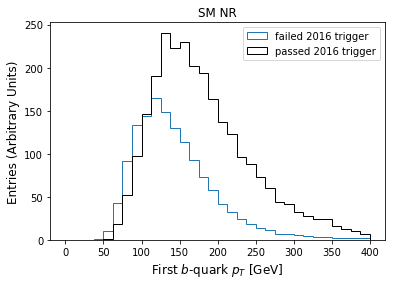

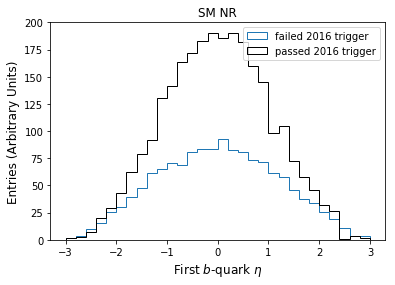

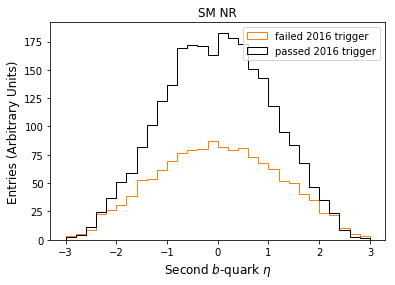

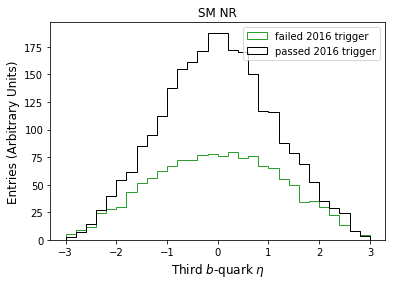

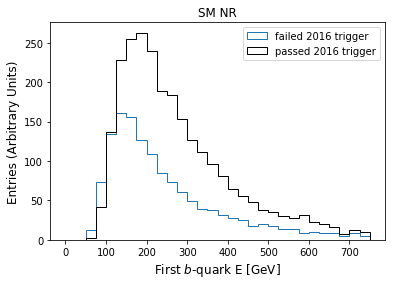

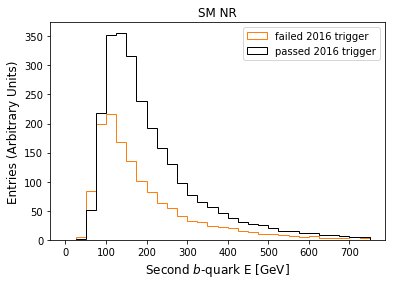

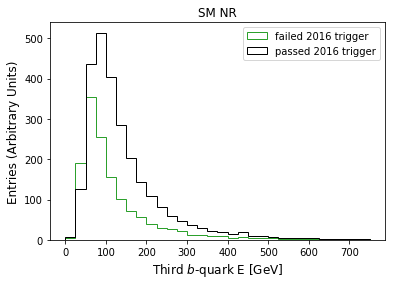

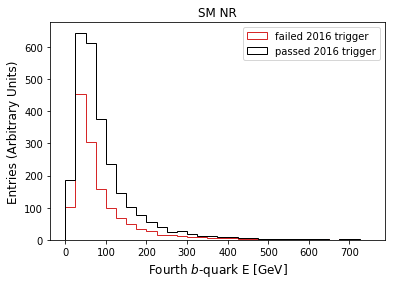

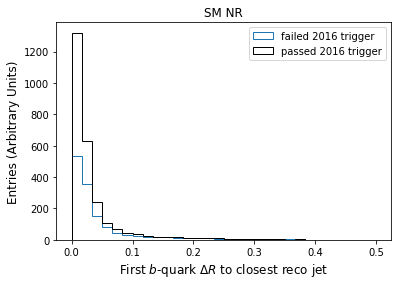

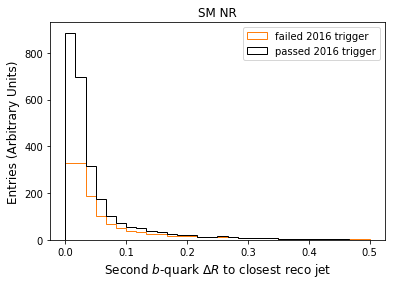

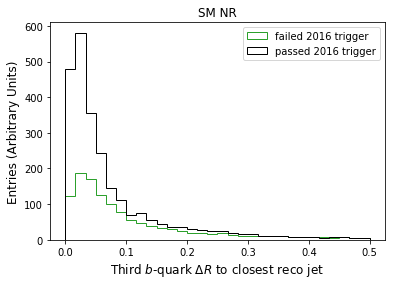

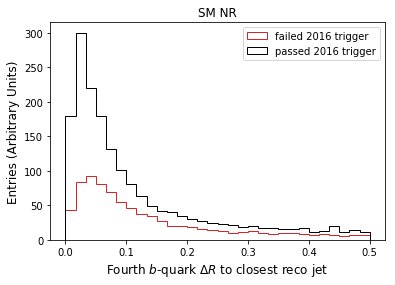

In [ ]:
for var, nBinsList, myRanges, xlabel in zip(jetVars, nBinsAll, myRangesAll, xlabels):
    
    for ib,blabel,nBins,myRange in zip(range(4), ['First','Second','Third','Fourth'], nBinsList, myRanges):
    
        key = 'b{}_{}'.format(ib,var)
    
        plt.hist(miniNtuple.loc[mask,key], bins=nBins, range=myRange, 
                 label='failed {} trigger'.format(trigger[:4]),
                 histtype='step', color="C{}".format(ib), #density=True, 
                 weights=miniNtuple.loc[mask,'mc_sf'])

        plt.hist(miniNtuple.loc[~mask,key], bins=nBins, range=myRange, 
                 label='passed {} trigger'.format(trigger[:4]),
                 histtype='step', color='k', #density=True, 
                 weights=miniNtuple.loc[~mask,'mc_sf'])

        plt.xlabel(blabel+' $b$-quark '+xlabel,fontsize=12)
        plt.ylabel("Entries (Arbitrary Units)",fontsize=12)
        plt.title('SM NR')
        plt.legend()
        
        plt.savefig('{}/{}.pdf'.format(figDir,key))
        plt.show()

Michael said look at the to talk meaningfully about the tail for $\Delta R$(truth,reco).

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


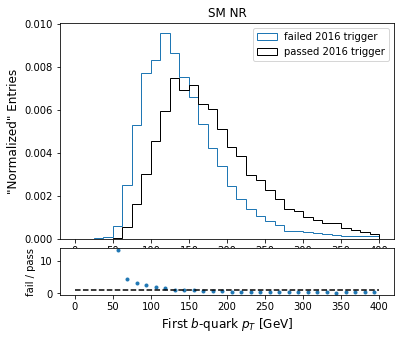

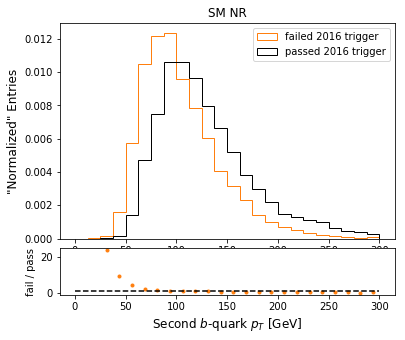

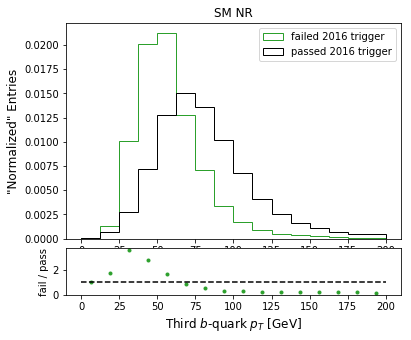

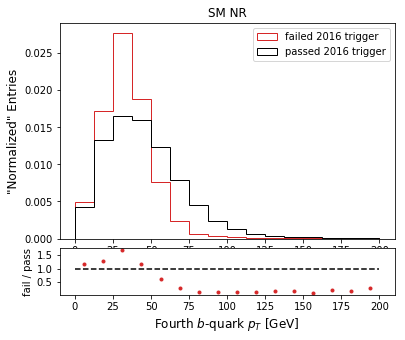

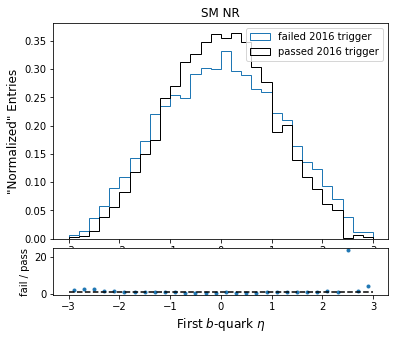

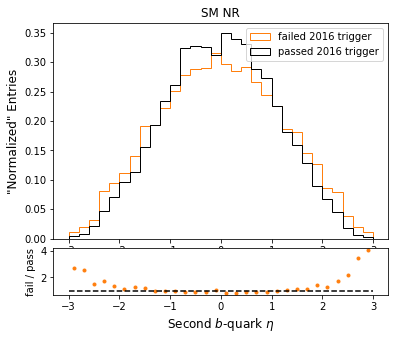

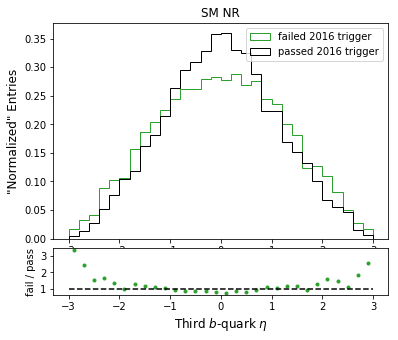

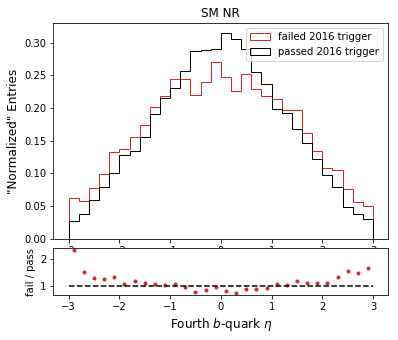

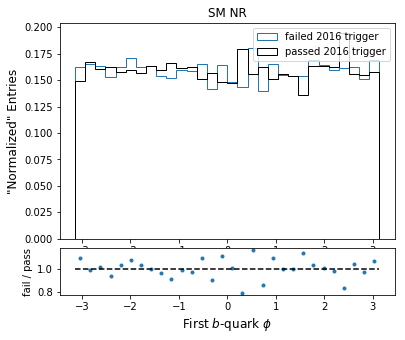

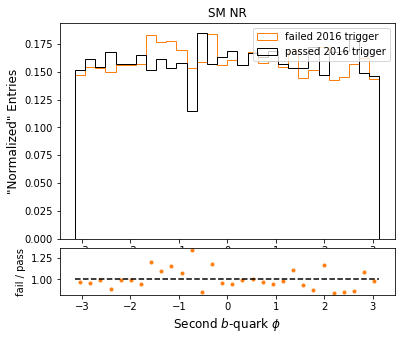

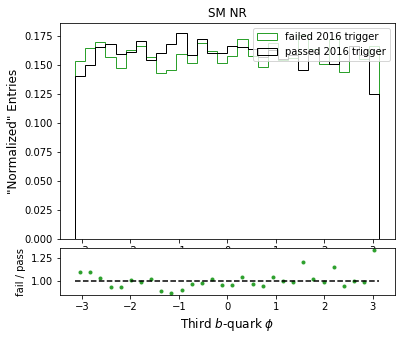

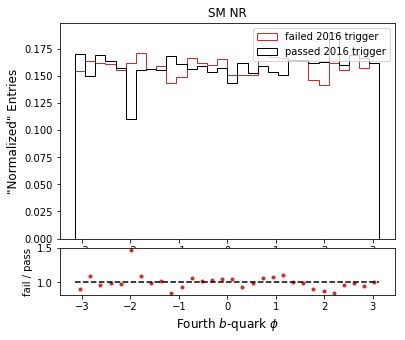

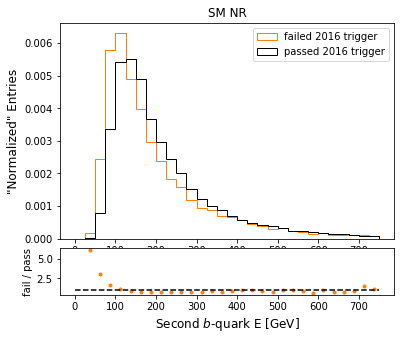

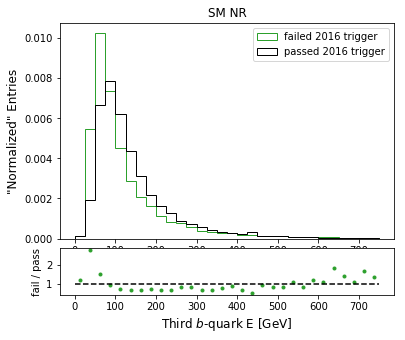

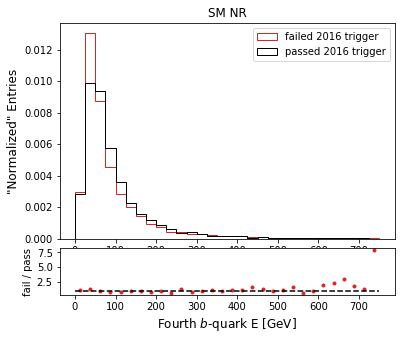

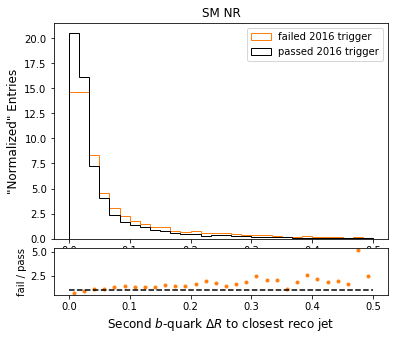

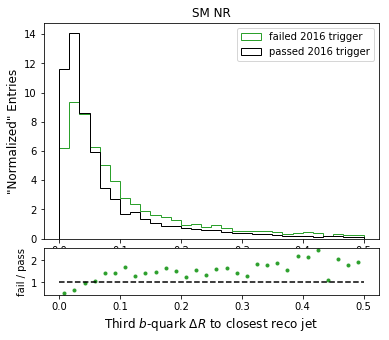

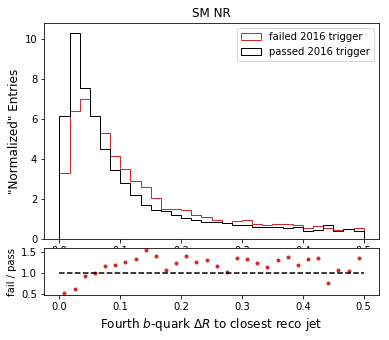

In [ ]:
for var, nBinsList, myRanges, xlabel in zip(jetVars, nBinsAll, myRangesAll, xlabels):
    
    for ib,blabel,nBins,myRange in zip(range(4), ['First','Second','Third','Fourth'], nBinsList, myRanges):
    
        key = 'b{}_{}'.format(ib,var)
        c = "C{}".format(ib)
    
        fig = plt.figure(figsize=(6,5))
        gs = gridspec.GridSpec(5,1)
        ax1 = fig.add_subplot(gs[:4,0])
        ax2 = fig.add_subplot(gs[4:,0])
    
        n_fail,edg,_ = ax1.hist(miniNtuple.loc[mask,key], bins=nBins, range=myRange, 
                                label='failed {} trigger'.format(trigger[:4]),
                                histtype='step', color=c, density=True, 
                                weights=miniNtuple.loc[mask,'mc_sf'])

        n_pass,edg,_ = ax1.hist(miniNtuple.loc[~mask,key], bins=nBins, range=myRange, 
                                label='passed {} trigger'.format(trigger[:4]),
                                histtype='step', color='k', density=True, 
                                weights=miniNtuple.loc[~mask,'mc_sf'])

        ax2.plot(0.5 * (edg[:-1]+edg[1:]), n_fail / n_pass, 
                 color=c, marker='.', linewidth=0)
        
        
        ax1.set_ylabel("\"Normalized\" Entries",fontsize=12)
        ax1.set_title('SM NR')
        ax1.legend()
        
        ax2.set_xlabel(blabel+' $b$-quark '+xlabel,fontsize=12)
        ax2.set_ylabel('fail / pass')
        
        ax2.plot([edg[0],edg[-1]],[1]*2,'k--')
        
        
        plt.savefig('{}/{}_ratio.pdf'.format(figDir,key))
        plt.show()

Ok, I guess if we're on the trigger turn on curves, it's not really that instructive how we're systematically limiting the types of jets that we reconstruct?

## Event displays

Note: There's no muon-in-jet correction in this event display, and the solid line just means that the jet was b-tagged.


Ok, so before I was printing *all* of the triggers that passed w/o reference to whether these triggers were pre-scaled or not. But, Michael and Rafael said I should only be plotting the *unprescaled* triggers. Rafael said there was a way to save this information in XhhCommon, using a pre-selection and HelpTreeBase::AddTrigger().

But, I decided to instead just look up *which* triggers were *not* pre-scaled in the [Lowest un-prescaled triggers per data-taking period](https://twiki.cern.ch/twiki/bin/view/Atlas/LowestUnprescaled) twiki, because this also allowed me to separate the trigger streams *by year*, which is something that *I think* I'm interested in :)



**Which triggers should I consider?**

Let's briefly take a look at what [XhhCommon](https://gitlab.cern.ch/hh4b/XhhCommon/blob/21.2.61-FEB2019-Prod/sources/XhhCommon/config/combinedMaster.py) is saving:

Mostly jet, $H_T$, some electron and muon triggers.

The single jet thresholds went *up* during the data-taking year, which makes sense (I guess), but I'm not sure if this means I should print them out or not?


Note - the single jet triggers have thresholds going from 340 GeV to like 380 GeV, and the multi-jet triggers require three jets with $p_T$ > 175 GeV ot 200 GeV at the end of 2016. When I looked at events which passed L1, but not the $b$-triggers, it didn't look like they were going to pass these single jet triggers (except for the boosted events, which the resolved analysis wouldn't pick up anyways), so I think it's ok to just print out the single b-triggers

In the b-jet trigger list, the triggers from period D4 were active for the whole year, so I'll just compare against them.


In [ ]:
jetTriggers = []

bTriggers = [
    # single b
    "HLT_j175_bmv2c2040_split", 
    "HLT_j225_bmv2c2060_split",
    "HLT_j275_bmv2c2070_split",
    "HLT_j300_bmv2c2077_split",
    "HLT_j360_bmv2c2085_split", 
    "HLT_j55_bmv2c2060_split_ht500_L14J15", 
    "HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25",
    # 2 b
    "HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25",
    "HLT_2j45_bmv2c2077_split_3j45", # Seeded from L15J15
    "HLT_2j45_bmv2c2077_split_3j45_L14J15.0ETA25",
    "HLT_2j55_bmv2c2060_split_ht300_L14J15",
    "HLT_2j70_bmv2c2060_split_j70",
    "HLT_2j75_bmv2c2070_split_j75",
    "HLT_j100_2j55_bmv2c2060_split", 
    "HLT_j150_bmv2c2060_split_j50_bmv2c2060_split",
    "HLT_j175_bmv2c2060_split_j50_bmv2c2050_split",
]


L1Triggers = [
    'L1_4J20',
    'L1_J100',
    'L1_3J25.0ETA23',
    'L1_4J15.0ETA25',
    'L1_J75_3J20',
    #'L1_HT.*'
]

**Other trigger in XhhCommon that were not in the 2016 lowest unprescaled triggers list that are saved by XhhCommon:**
- `HLT_e24_lhtight_iloose`

Note: the `HLT_mu26_imedium` *was* in the 2016 lowest unprescaled triggers list for period D4-G2. However, in the period D4-E there's an ataskerisk that says is was prescaled when the luminosity was larger than 1e34.


In [ ]:
miniNtuple.head()

nresolvedJets  nmuon  \
564518              4      0   
564066              5      0   
564074              5      0   
565297              4      0   
565590              7      0   

                                           passedTriggers  \
564518  [b'HLT_j150_bmv2c2077_split_j50_bmv2c2077_spli...   
564066  [b'HLT_j150_bmv2c2077_split_j50_bmv2c2077_spli...   
564074  [b'HLT_j150_bmv2c2077_split_j50_bmv2c2077_spli...   
565297  [b'HLT_j150_bmv2c2077_split_j50_bmv2c2077_spli...   
565590  [b'HLT_j175_bmv2c2050_split', b'HLT_j175_bmv2c...   

                                           resolvedJets_E  \
564518        [421.52124, 164.80742, 125.78658, 94.92272]   
564066  [1127.0175, 829.2315, 223.59744, 174.03233, 14...   
564074  [305.1207, 398.6563, 93.756004, 36.775097, 36....   
565297        [263.85413, 122.4306, 106.82293, 44.833916]   
565590  [1577.7572, 2064.063, 88.60485, 130.87675, 47....   

                                          resolvedJets_pt  \
564518        [219.50876, 163.1676, 124.580574, 78.40657]   
564066  [225.49184, 218.40558, 100.069855, 36.207504, ...   
564074  [256.35953, 212.84236, 47.00225, 29.401716, 26...   
565297      [198.93936, 115.142784, 83.763016, 36.727955]   
565590  [1244.1014, 1051.0204, 86.124886, 83.06029, 40...   

                                         resolvedJets_phi  \
564518    [-3.0415924, -0.38584673, 0.45952395, 2.458464]   
564066  [2.7338464, -0.2843658, -1.6629074, 1.5579474,...   
564074  [-3.062036, -0.04552139, 1.023499, 1.4849138, ...   
565297     [1.3332094, -2.2262259, -1.1321603, 2.0598605]   
565590  [-2.257817, 0.86138994, 0.81132966, -2.2956107...   

                                         resolvedJets_eta  \
564518  [1.2687927, 0.115122564, -0.05440677, 0.62411165]   
564066  [-2.2917786, 2.0092487, 1.4405354, 2.2512991, ...   
564074  [-0.601422, -1.2390879, -1.3092326, -0.6784658...   
565297     [-0.7849874, 0.34634608, 0.7245773, -0.641943]   
565590  [0.7119703, -1.293158, 0.18936242, -1.0224354,...   

                                      resolvedJets_MV2c10  \
564518      [0.9985546, 0.9995821, 0.9969277, 0.99993205]   
564066  [-0.24841115, 0.95415205, 0.98565876, -0.59982...   
564074  [0.97076905, 0.9070776, -0.756727, 0.9999316, ...   
565297       [0.9981939, 0.999882, 0.93076205, -0.916671]   
565590  [0.10255633, 0.6833259, -0.9268299, -0.5523484...   

       resolvedJets_HadronConeExclTruthLabelID  \
564518                            [5, 5, 5, 5]   
564066                         [0, 5, 5, 5, 0]   
564074                         [5, 5, 4, 5, 5]   
565297                            [5, 5, 5, 0]   
565590                   [5, 5, 0, 0, 0, 0, 0]   

       resolvedJets_is_MV2c10_FixedCutBEff_70  ...    HCs_dr HCs_angle  \
564518                           [1, 1, 1, 1]  ...  3.268338  2.121416   
564066                        [0, 1, 1, 0, 0]  ...       NaN       NaN   
564074                        [1, 1, 0, 1, 1]  ...       NaN       NaN   
565297                           [1, 1, 1, 0]  ...       NaN       NaN   
565590                  [0, 0, 0, 0, 0, 0, 0]  ...       NaN       NaN   

       fourGoodJets    MDR   MDpT cut_deta_hh  cut_Xwt  cut_Xhh correctPair  \
564518         True   True   True        True     True     True           1   
564066        False  False  False       False    False    False          -1   
564074        False  False  False       False    False    False          -1   
565297        False  False  False       False    False    False          -1   
565590        False  False  False       False    False    False          -1   

       badJets  
564518   False  
564066    True  
564074    True  
565297    True  
565590    True  

[5 rows x 180 columns]

In [ ]:
for ti in miniNtuple.loc[564518,'passedTriggers']:
    print(ti)

b'HLT_j150_bmv2c2077_split_j50_bmv2c2077_split'
b'HLT_j150_bmv2c2060_split_j50_bmv2c2060_split'
b'HLT_j175_bmv2c2060_split_j50_bmv2c2050_split'
b'HLT_j175_bmv2c2050_split'
b'HLT_j175_bmv2c2040_split'
b'HLT_j175_bmv2c2077_split'
b'HLT_j100_2j55_bmv2c2060_split'
b'HLT_j100_2j55_bmv2c2060_split_L1J85_3J30'
b'HLT_j100_2j55_bmv2c2070_split'
b'HLT_j100_2j55_bmv2c2077_split'
b'HLT_j225_bmv2c2070_split'
b'HLT_j175_bmv2c2077_split_j60_bmv2c2077_split'
b'HLT_j225_bmv2c2060_split'
b'HLT_j225_bmv2c2077_split'
b'HLT_j225_bmv2c2085_split'
b'HLT_j65_bmv2c2070_split_3j65_L14J15'
b'HLT_j70_bmv2c2077_split_3j70_L14J15'
b'HLT_j75_bmv2c2077_split_3j75_L14J15'
b'HLT_2j45_bmv2c2077_split_2j45_L14J15'
b'HLT_2j45_bmv2c2070_split_2j45_L14J15'
b'HLT_2j35_bmv2c2070_split_2j35_L14J15'
b'HLT_2j35_bmv2c2060_split_2j35_L14J15'
b'HLT_j75_bmv2c2070_split_3j75_L14J15'
b'HLT_j50_bmv2c2040_split_3j50_L14J15'
b'HLT_2j65_bmv2c2070_split_j65'
b'HLT_2j70_bmv2c2077_split_j70'
b'HLT_2j70_bmv2c2070_split_j70'
b'HLT_2j75_bmv2c20

b-triggers the event passed:
HLT_2j75_bmv2c2070_split_j75
HLT_j55_bmv2c2060_split_ht500_L14J15
HLT_2j75_bmv2c2070_split_j75
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25
L1_J100
L1_J75_3J20


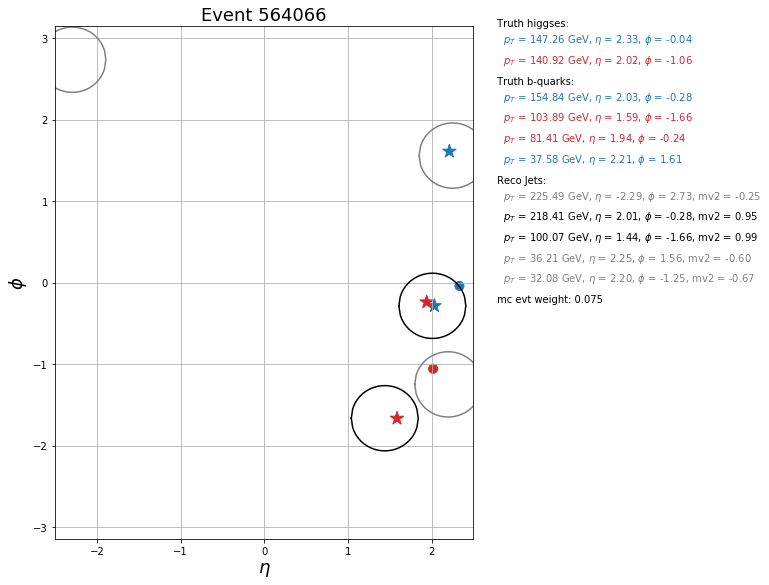

b-triggers the event passed:
HLT_j275_bmv2c2070_split
HLT_j300_bmv2c2077_split
HLT_j360_bmv2c2085_split
HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25
HLT_2j75_bmv2c2070_split_j75
HLT_j55_bmv2c2060_split_ht500_L14J15
HLT_2j75_bmv2c2070_split_j75
HLT_j360_bmv2c2085_split
HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25
L1_4J20
L1_J100
L1_J75_3J20


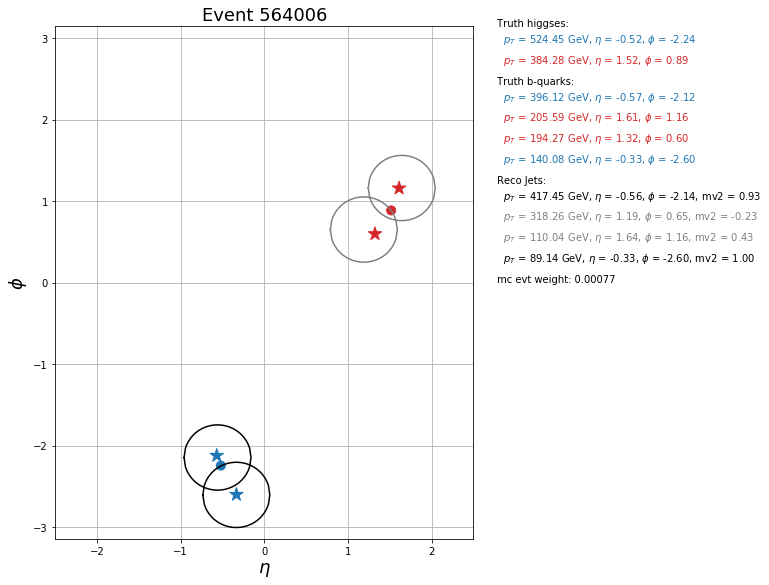

b-triggers the event passed:
L1 triggers the event passed:
L1_3J25.0ETA23
L1_J100
L1_J75_3J20


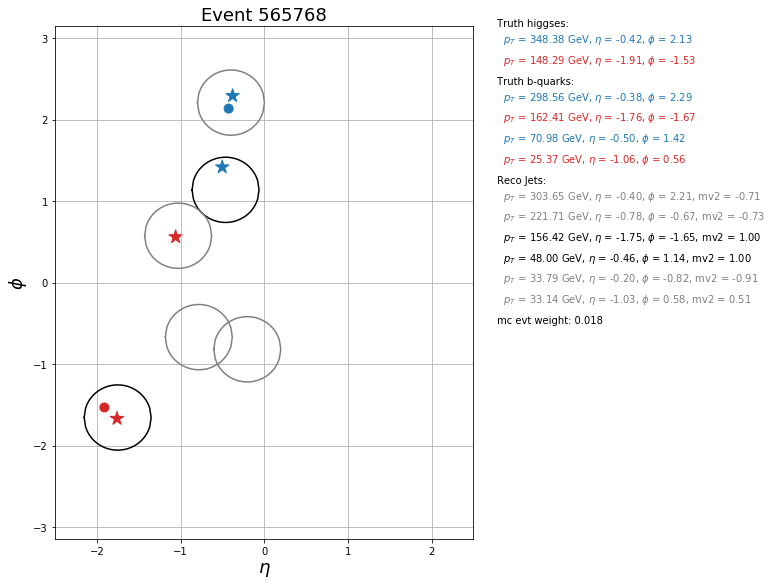

b-triggers the event passed:
HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25
HLT_2j45_bmv2c2077_split_3j45_L14J15.0ETA25
HLT_2j75_bmv2c2070_split_j75
HLT_2j45_bmv2c2077_split_3j45
HLT_j55_bmv2c2060_split_ht500_L14J15
HLT_2j45_bmv2c2077_split_3j45_L14J15.0ETA25
HLT_2j45_bmv2c2077_split_3j45
HLT_2j75_bmv2c2070_split_j75
HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25
L1_4J20
L1_J100
L1_J75_3J20


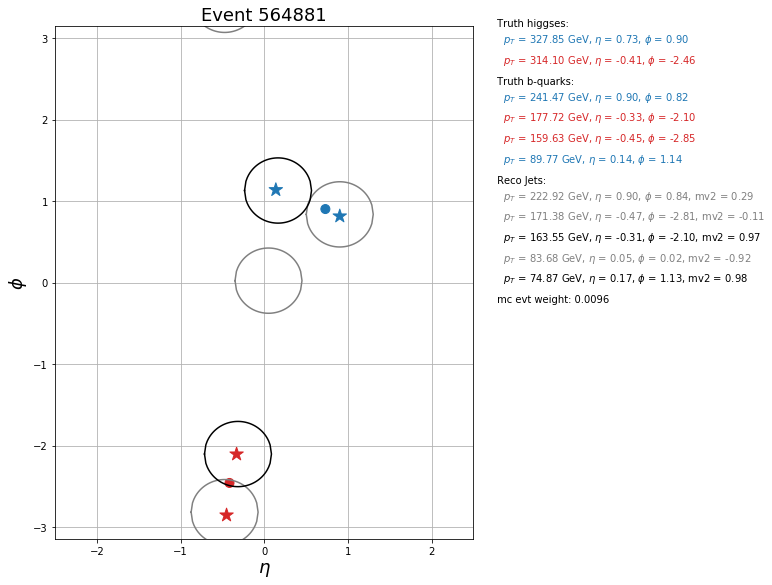

b-triggers the event passed:
HLT_j275_bmv2c2070_split
HLT_j300_bmv2c2077_split
HLT_j360_bmv2c2085_split
HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25
HLT_2j45_bmv2c2077_split_3j45_L14J15.0ETA25
HLT_2j45_bmv2c2077_split_3j45
HLT_2j45_bmv2c2077_split_3j45_L14J15.0ETA25
HLT_2j45_bmv2c2077_split_3j45
HLT_j360_bmv2c2085_split
HLT_j75_bmv2c2070_split_3j75_L14J15.0ETA25
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25
L1_4J20
L1_J100
L1_J75_3J20


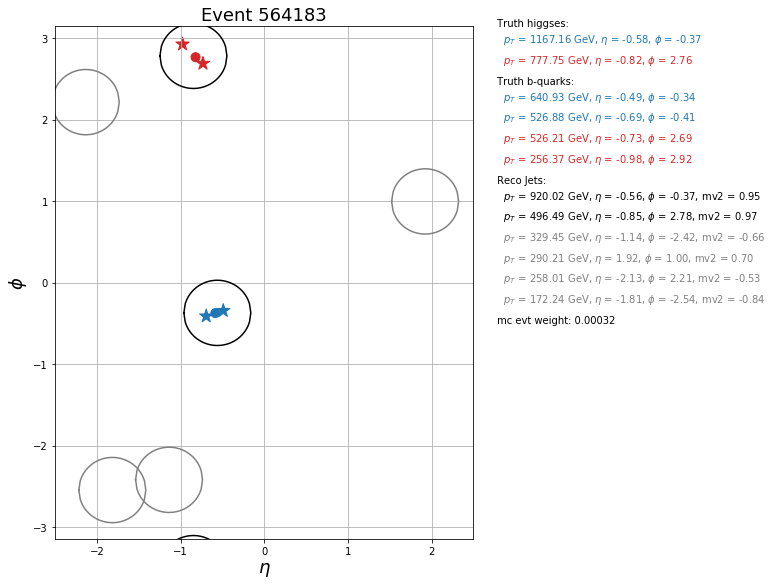

b-triggers the event passed:
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25


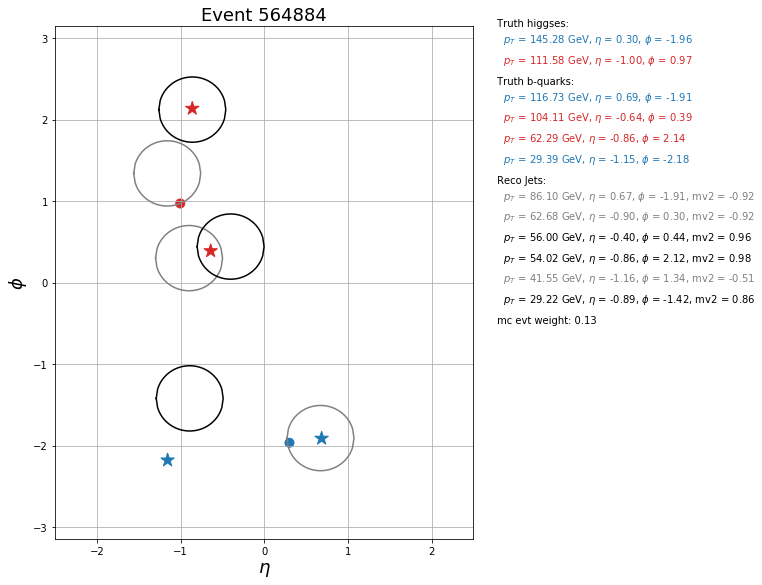

b-triggers the event passed:
HLT_j275_bmv2c2070_split
HLT_j300_bmv2c2077_split
HLT_j360_bmv2c2085_split
HLT_2j75_bmv2c2070_split_j75
HLT_j55_bmv2c2060_split_ht500_L14J15
HLT_2j75_bmv2c2070_split_j75
HLT_j360_bmv2c2085_split
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J20
L1_J100
L1_J75_3J20


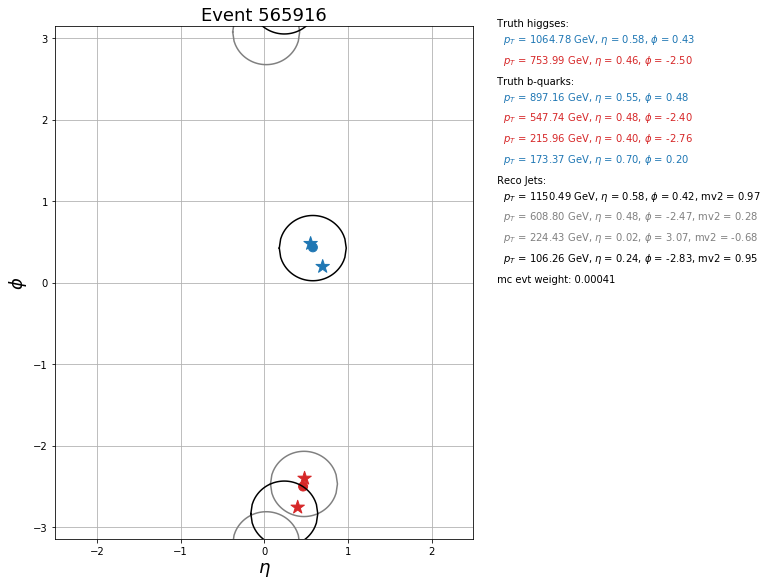

b-triggers the event passed:
L1 triggers the event passed:


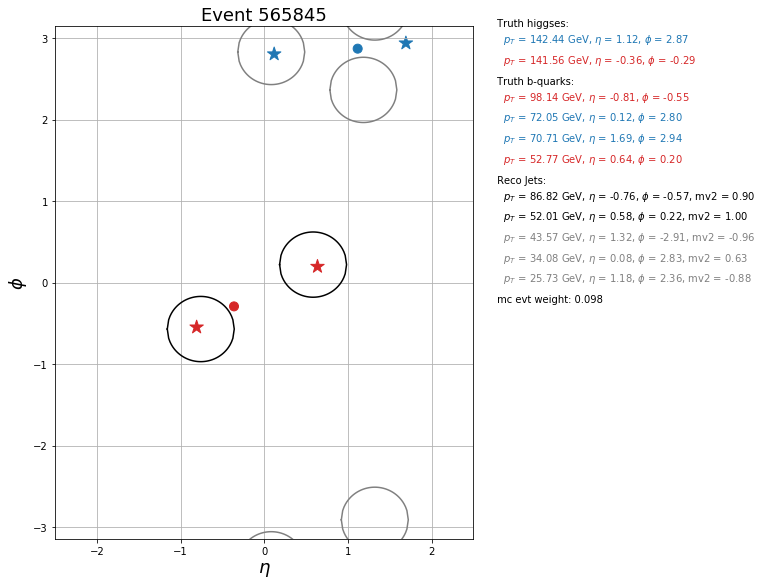

b-triggers the event passed:
L1 triggers the event passed:


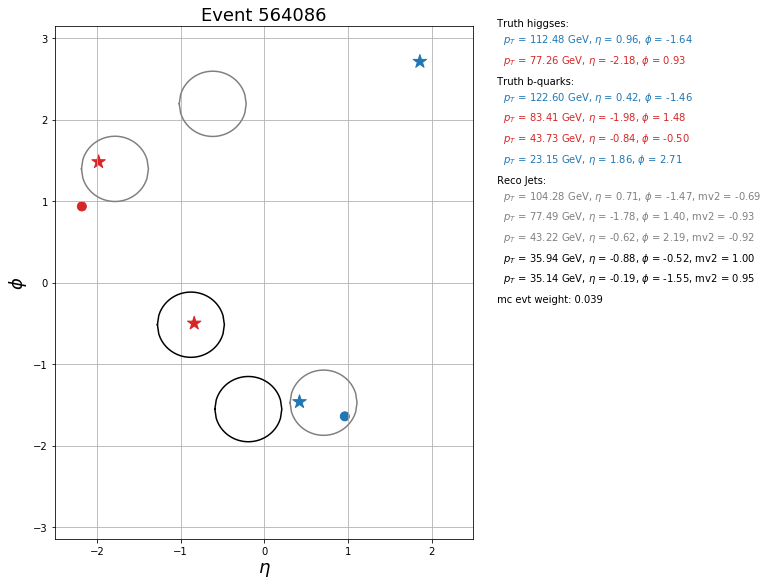

b-triggers the event passed:
HLT_j360_bmv2c2085_split
HLT_j360_bmv2c2085_split
L1 triggers the event passed:
L1_J100


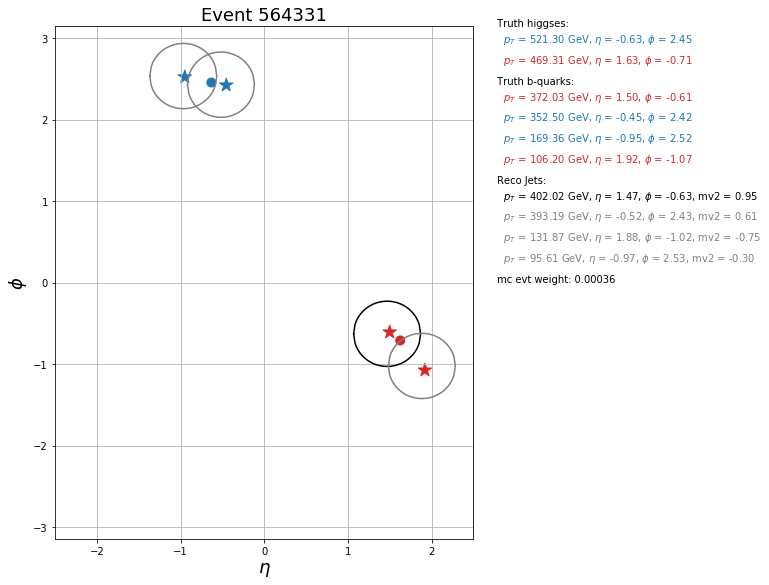

b-triggers the event passed:
HLT_j55_bmv2c2060_split_ht500_L14J15
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25
L1_4J20
L1_J100
L1_J75_3J20


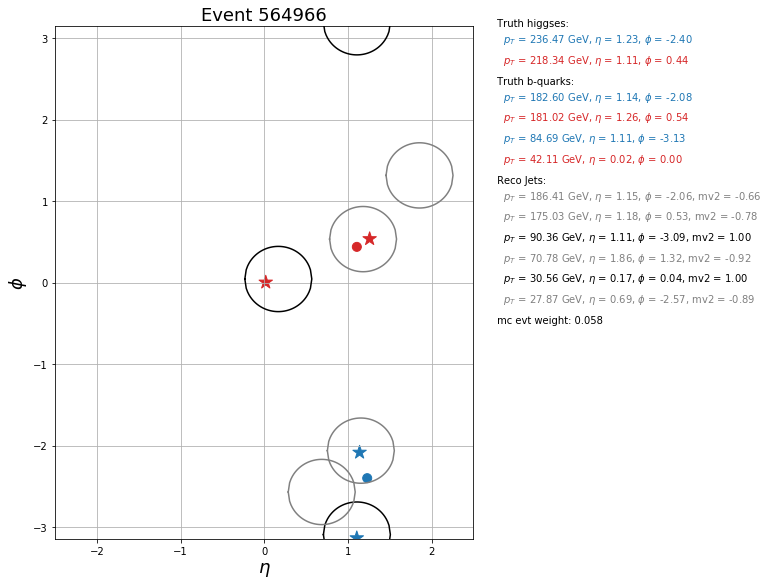

b-triggers the event passed:
L1 triggers the event passed:


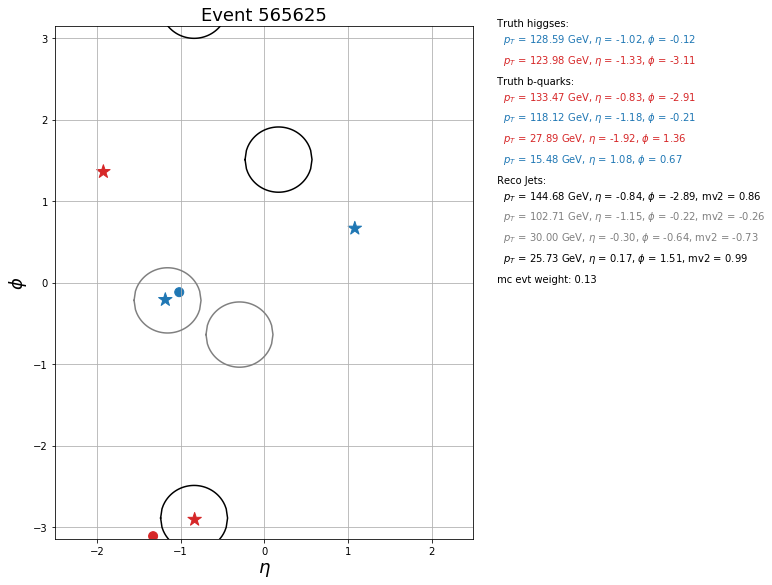

b-triggers the event passed:
L1 triggers the event passed:
L1_4J15.0ETA25


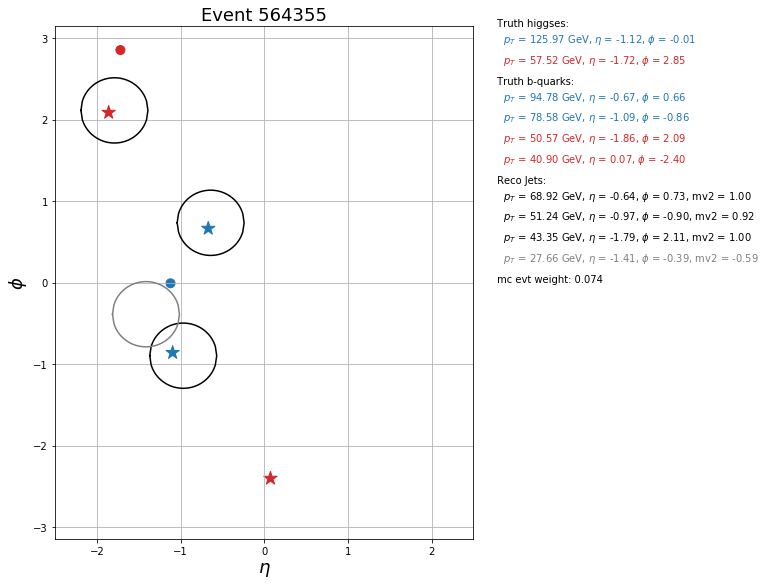

b-triggers the event passed:
L1 triggers the event passed:


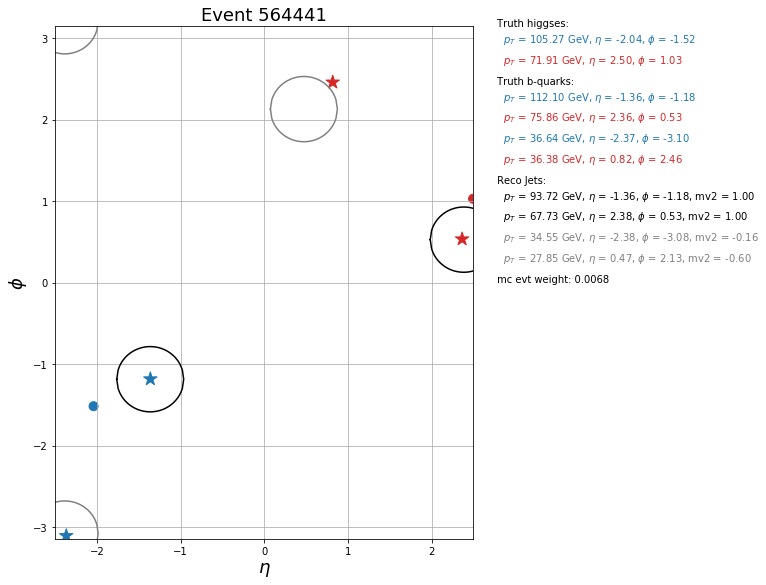

b-triggers the event passed:
HLT_2j75_bmv2c2070_split_j75
HLT_2j75_bmv2c2070_split_j75
L1 triggers the event passed:
L1_3J25.0ETA23
L1_J100
L1_J75_3J20


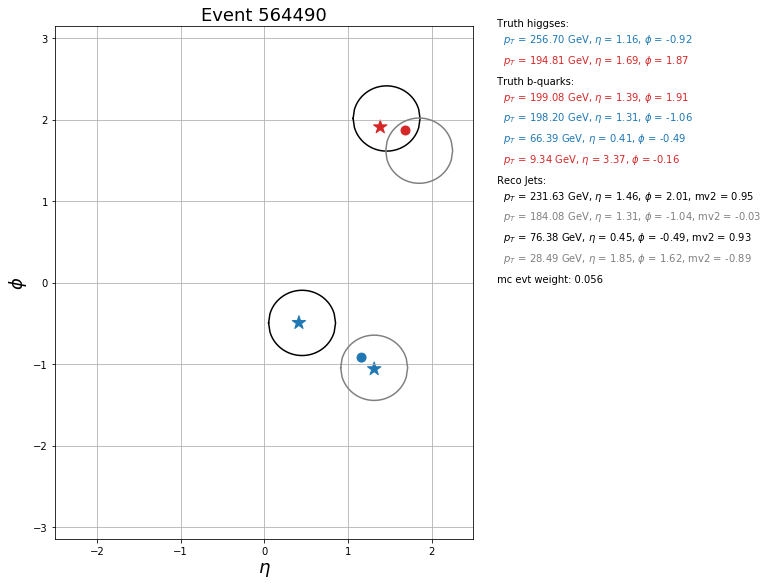

b-triggers the event passed:
L1 triggers the event passed:
L1_3J25.0ETA23


b-triggers the event passed:
HLT_j175_bmv2c2040_split
HLT_j175_bmv2c2040_split
L1 triggers the event passed:
L1_J100


b-triggers the event passed:
L1 triggers the event passed:
L1_3J25.0ETA23
L1_4J15.0ETA25
L1_4J20
L1_J100
L1_J75_3J20


b-triggers the event passed:
L1 triggers the event passed:


In [ ]:
evtDisplayDir = figDir + 'evtDisplays'

counter=0

for ievt, passedTrigger in miniNtuple[[trigger]].itertuples():

    if passedTrigger:
        continue
    
    print('b-triggers the event passed:')
    for ti in miniNtuple.loc[ievt,'passedTriggers']:
        if ti.decode() in bTriggers:
            print(ti.decode())
            
    print('L1 triggers the event passed:')
    for ti in miniNtuple.loc[ievt,'passedTriggers']:
        if ti.decode() in L1Triggers:
            print(ti.decode())
    
    
    truthInfo(ievt,miniNtuple,figDir=evtDisplayDir)
    counter += 1
    
    if counter == 20:
        break

**Conclusions:**

- There are *lots* of events that pass some of the b-triggers that use looser WPs.
- However, many of these only have 2 b-tags at the MV2 60% WP, so we wouldn't be able to use them anyways for combination (at least as the current analyses stand).
- The events that did have 3 $b$-tags seemed like we would lose them for other reasons (such as one of the quarks not getting matched to a jet), so I think the conclusion here is we *don't* want to reoptimize the 2016 triggers.
